### Importing requirements:

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
from skimage.io import imread, imshow

### Reading images and splitting the dataset:

In [2]:
random.seed(1234)

X, Y = [], []
dir_ = {'data/male/': 1, 'data/female/': 0}
for d, y in dir_.items():
    for i in os.listdir(d):
        f = os.path.join(d, i)
        if os.path.isfile(f) and i.endswith(".png"):
            img = imread(f)/255.0
            X.append(img)
            Y.append(y)

tmp = list(zip(X, Y))
random.shuffle(tmp)
X, Y = zip(*tmp)
test_size = int(0.05 * len(X))
X_test, Y_test = np.array(X[-test_size:], dtype=np.float32), np.array(Y[-test_size:])
X_train, Y_train = np.array(X[0:-test_size], dtype=np.float32), np.array(Y[0:-test_size])

### Defining our NN:

In [3]:
def classifier_model_fn(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 25*25])
    layer_1 = tf.layers.dense(inputs=input_layer, units=200, activation=tf.nn.relu)
    layer_output = tf.layers.dense(inputs=layer_1, units=2)
    predictions = { 
        "prob": tf.nn.softmax(layer_output), 
        "output": tf.argmax(input=layer_output, axis=1) 
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions, 
                                          export_outputs={
                                              "prediction": tf.estimator.export.ClassificationOutput(
                                                  scores=predictions["prob"]
                                              )
                                          })
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    # out_clipped = tf.clip_by_value(layer_output,1e-10,1e10)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=layer_output)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
        labels=labels, predictions=predictions["output"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Creating an Estimator:

In [4]:
# Create the Estimator
mf_classifier = tf.estimator.Estimator(
    model_fn=classifier_model_fn, model_dir="/tmp/mf_classifier")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1103b23d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/mf_classifier', '_save_summary_steps': 100}


### Training the Estimator:

In [5]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mf_classifier.train(
    input_fn=train_input_fn,
    steps=8000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mf_classifier/model.ckpt.
INFO:tensorflow:loss = 0.9710674, step = 1
INFO:tensorflow:global_step/sec: 488.25
INFO:tensorflow:loss = 0.51167893, step = 101 (0.206 sec)
INFO:tensorflow:global_step/sec: 545.664
INFO:tensorflow:loss = 0.4731263, step = 201 (0.183 sec)
INFO:tensorflow:global_step/sec: 529.602
INFO:tensorflow:loss = 0.42376804, step = 301 (0.189 sec)
INFO:tensorflow:global_step/sec: 543.54
INFO:tensorflow:loss = 0.38365522, step = 401 (0.184 sec)
INFO:tensorflow:global_step/sec: 566.894
INFO:tensorflow:loss = 0.47763625, step = 501 (0.177 sec)
INFO:tensorflow:global_step/sec: 549.553
INFO:tensorflow:loss = 0.27807254, step = 601 (0.182 sec)
INFO:tensorflow:global_step/sec: 511.527
INFO:tensor

INFO:tensorflow:Saving checkpoints for 8000 into /tmp/mf_classifier/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00807002.


### Evaluating our Estimator:

In [6]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test},
    y=Y_test,
    shuffle=False)
eval_results = mf_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-21-19:38:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mf_classifier/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-21-19:38:59
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.8969697, global_step = 8000, loss = 0.30619115
{'loss': 0.30619115, 'global_step': 8000, 'accuracy': 0.8969697}


### Predicting Output:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mf_classifier/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Users/jp/python/ml/ml_notebooks/venv/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/jp/python/ml/ml_notebooks/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


['male']


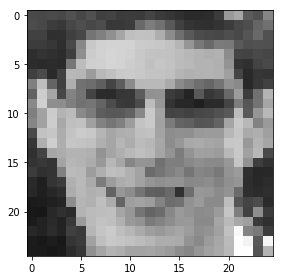

In [7]:
# Check the model
check_index=110
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test[check_index]}, shuffle=False)
predict_results = mf_classifier.predict(input_fn=predict_input_fn, predict_keys=["output"])
imshow(X_test[check_index])
print(["male" if i["output"] else "female" for i in predict_results])

### Exporting our model:
Exported model will be deployed using tensorflow-serving

In [8]:
mf_classifier.export_savedmodel("./models/NN/",
                                tf.estimator.export.build_parsing_serving_input_receiver_fn({
                                    "x": tf.FixedLenFeature(shape=[25,25], dtype=tf.float32)
                                }))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'prediction']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Restoring parameters from /tmp/mf_classifier/model.ckpt-8000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./models/temp-1524339561/saved_model.pb


'./models/1524339561'